In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import seaborn as sns
import shutil
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report

### define directories and create a list of filepaths and labels

In [3]:
basaltDir=r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Basalt'
graniteDir=r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Granite'
marbleDir=r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Marble'
quartziteDir=r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Quartzite'
coalDir=r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Coal'
limestoneDir=r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Limestone'
sandstoneDir=r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Sandstone'
alexandriteDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Alexandrite'
almandineDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Almandine'
amazoniteDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Amazonite'
amberDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Amber'
amethystDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Amethyst'
ametrineDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Ametrine'
andalusiteDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Andalusite'
andraditeDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Andradite'
aquamarineDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Aquamarine'
aventurineGreenDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Aventurine Green'
aventurineYellowDir = r'/content/drive/MyDrive/Mestrado/2024_2/Qualification/gems/train_no_background/Aventurine Yellow'
dirlist=[basaltDir, graniteDir, marbleDir, quartziteDir, coalDir, limestoneDir, sandstoneDir, alexandriteDir, almandineDir, amazoniteDir,
        amberDir, amethystDir, ametrineDir, andalusiteDir, andraditeDir, aquamarineDir, aventurineGreenDir, aventurineYellowDir]
classes=['basalt', 'granite', 'marble', 'quartzite', 'coal', 'limestone', 'sandstone', 'alexandrite', 'almandine', 'amazonite',
        'amber', 'amethyst', 'ametrine', 'andalusite', 'andradite', 'aquamarine', 'aventurine green', 'aventurine yellow']
filepaths=[]
labels=[]
for d,c in zip(dirlist, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1943    labels:  1943


### create a dataframe

In [4]:
import pandas as pd

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

balance = df['labels'].value_counts()
print("Distribuição inicial das classes:")
print(balance)

#min_count = balance.min()

#balanced_df = df.groupby('labels').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

#final_balance = balanced_df['labels'].value_counts()
#print("\nDistribuição final das classes:")
#print(final_balance)
balanced_df = df
print(balanced_df.head())


Distribuição inicial das classes:
labels
quartzite            380
marble               288
limestone            276
sandstone            265
coal                 208
basalt                80
granite               70
aventurine green      45
aquamarine            36
amethyst              35
ametrine              35
aventurine yellow     34
alexandrite           34
amazonite             32
andalusite            32
almandine             31
amber                 31
andradite             31
Name: count, dtype: int64
                                           filepaths  labels
0  /content/drive/MyDrive/Mestrado/2024_2/Qualifi...  basalt
1  /content/drive/MyDrive/Mestrado/2024_2/Qualifi...  basalt
2  /content/drive/MyDrive/Mestrado/2024_2/Qualifi...  basalt
3  /content/drive/MyDrive/Mestrado/2024_2/Qualifi...  basalt
4  /content/drive/MyDrive/Mestrado/2024_2/Qualifi...  basalt


In [5]:
print(df['labels'].value_counts())


labels
quartzite            380
marble               288
limestone            276
sandstone            265
coal                 208
basalt                80
granite               70
aventurine green      45
aquamarine            36
amethyst              35
ametrine              35
aventurine yellow     34
alexandrite           34
amazonite             32
andalusite            32
almandine             31
amber                 31
andradite             31
Name: count, dtype: int64


### data set is severely unbalanced

### create some augmented images for basalt and marble clases which are wy underrepresented

In [6]:
out_dir=r'./'
aux_dir_path=os.path.join(out_dir, 'Aux')
if os.path.isdir(aux_dir_path)== False:
    os.mkdir(aux_dir_path)
else:
    shutil.rmtree(aux_dir_path)
    os.mkdir(aux_dir_path)
almandine_path=os.path.join(aux_dir_path, 'almandine')
os.mkdir(almandine_path)
andradite_path=os.path.join(aux_dir_path, 'andradite')
os.mkdir(andradite_path)
print(os.listdir(aux_dir_path))
under_classes=[almandineDir, andraditeDir]
# Get the number of images for each class to define the array shape
basalt_num_images = len(os.listdir(almandineDir))
granite_num_images = len(os.listdir(andraditeDir))

basalt_array=np.zeros((basalt_num_images,228,228,3)) # Initialize with correct size
granite_array=np.zeros((granite_num_images,228,228,3))  # Initialize with correct size

for d in under_classes:
    if d==basaltDir:
        darray=basalt_array
        dpath=almandine_path
        batch_size=20
    elif d==graniteDir:
        darray=granite_array
        dpath=andradite_path
        batch_size=20
    else:
        darray=granite_array
        dpath=andradite_path
        batch_size=20
    flist=os.listdir(d)
    for i, f in enumerate(flist):
        fpath=os.path.join(d,f)
        img=cv2.imread(fpath)
        img=cv2.resize(img,(228,228))
        darray[i]=img
    gen=ImageDataGenerator( horizontal_flip=True, rotation_range=30, zoom_range=.2,
                          height_shift_range=.2, width_shift_range=.2).flow(darray, batch_size=batch_size, shuffle=True, save_to_dir=dpath, )
    next(gen)
    next(gen)
basalt_list=os.listdir(almandine_path)
andradite_list=os.listdir(andradite_path)
print (len(basalt_list), '  ', len(andradite_list))

['andradite', 'almandine']
0    62


### create data frames from auxiliary images and append to original dataframe

In [7]:
labels=[]
filepaths=[]
sdir=aux_dir_path
slist=os.listdir(sdir)
for klass in slist:
    class_path=os.path.join(sdir, klass)
    flist=os.listdir(class_path)
    for f in flist:
        fpath=os.path.join(class_path,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
aux_df=pd.concat([Fseries, Lseries], axis=1)
print(aux_df.head())
print(aux_df['labels'].value_counts())
print('len of df: ', len(balanced_df), '  len of aux_df: ', len(aux_df))
balanced_df=pd.concat([balanced_df,aux_df], axis=0).reset_index(drop=True)
print (len(balanced_df))
print(balanced_df['labels'].value_counts())

                      filepaths     labels
0  ./Aux/andradite/_28_1947.png  andradite
1  ./Aux/andradite/_15_8600.png  andradite
2   ./Aux/andradite/_2_6593.png  andradite
3   ./Aux/andradite/_9_1070.png  andradite
4  ./Aux/andradite/_14_8809.png  andradite
labels
andradite    62
Name: count, dtype: int64
len of df:  1943   len of aux_df:  62
2005
labels
quartzite            380
marble               288
limestone            276
sandstone            265
coal                 208
andradite             93
basalt                80
granite               70
aventurine green      45
aquamarine            36
ametrine              35
amethyst              35
alexandrite           34
aventurine yellow     34
andalusite            32
amazonite             32
almandine             31
amber                 31
Name: count, dtype: int64


### create train_df, test_df, valid_df

In [8]:
height=224
width=224
channels=3
batch_size=24
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(balanced_df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print (len(train_df), len(test_df), len(valid_df))
vcounts=train_df['labels'].value_counts()
print (vcounts)
vmin=np.min(list(vcounts))

1604 200 201
labels
quartzite            306
marble               233
limestone            220
sandstone            207
coal                 170
andradite             76
basalt                64
granite               51
aventurine green      38
aquamarine            31
aventurine yellow     30
amethyst              28
alexandrite           27
andalusite            26
almandine             26
ametrine              25
amazonite             24
amber                 22
Name: count, dtype: int64


### balance the data set so all classes have an equal number of samples

In [9]:
file_count = vmin
samples = []

for category in train_df['labels'].unique():
    # Ignorar as classes "quartzite" e "marble"
    if category in ['quartzite', 'marble']:
        continue

    # Seleção das amostras para as outras classes
    category_slice = train_df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False, random_state=1))

# Manter as amostras originais de "quartzite" e "marble"
excluded_classes = train_df.query("labels in ['quartzite', 'marble']")
samples.append(excluded_classes)

# Concatenar e embaralhar as amostras
train_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Verificar os resultados
print(train_df['labels'].value_counts())
print(len(train_df))


labels
quartzite            306
marble               233
granite               22
almandine             22
alexandrite           22
limestone             22
andalusite            22
aquamarine            22
coal                  22
amazonite             22
basalt                22
aventurine yellow     22
amber                 22
sandstone             22
ametrine              22
amethyst              22
aventurine green      22
andradite             22
Name: count, dtype: int64
891


### make train, test, valid generators

In [10]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def apply_watershed(img):
    # Converte o tensor de float32 para uint8
    img = (img * 255).astype(np.uint8)

    # Verifica se a imagem está no formato correto (RGB)
    if img.dtype != np.uint8 or len(img.shape) != 3 or img.shape[2] != 3:
        raise ValueError("A imagem de entrada deve ser uma imagem RGB com dtype uint8.")

    # Converte a imagem RGB para escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Aplica o filtro de gradiente (Sobel)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient = cv2.magnitude(grad_x, grad_y)

    # Normaliza para [0, 255]
    gradient = cv2.normalize(gradient, None, 0, 255).astype(np.uint8)

    # Aplica threshold para gerar uma máscara binária
    _, binary = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Encontrar marcadores usando connectedComponents
    num_labels, markers = cv2.connectedComponents(binary)

    # Ajusta os marcadores para o formato necessário (CV_32SC1)
    markers = markers.astype(np.int32)

    # Aplica Watershed
    markers = cv2.watershed(img, markers)

    # Opcional: Delimita bordas detectadas em vermelho
    img[markers == -1] = [255, 0, 0]

    return img.astype(np.float32)  # Normaliza novamente para o intervalo [0, 1]

def scalar(img):  # Aplica a transformação watershed
    #img = apply_watershed(img)
    img=img/255.0
    return img  # Escala entre -1 e 1

# Geradores de dados
trgen = ImageDataGenerator(preprocessing_function=scalar)
tvgen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = trgen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=batch_size
)
test_gen = tvgen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=batch_size
)
valid_gen = tvgen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=batch_size
)


Found 885 validated image filenames belonging to 18 classes.
Found 200 validated image filenames belonging to 18 classes.
Found 201 validated image filenames belonging to 18 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 6 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0.

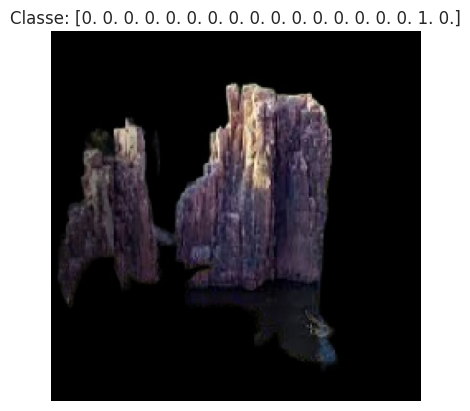

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0.

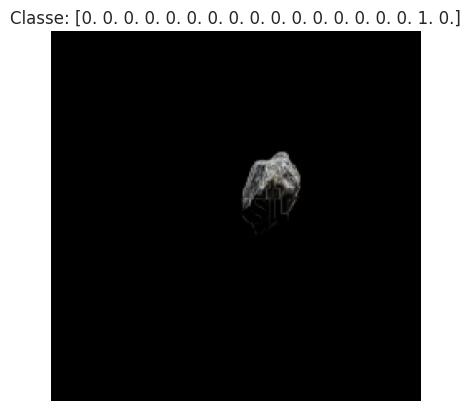

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0.

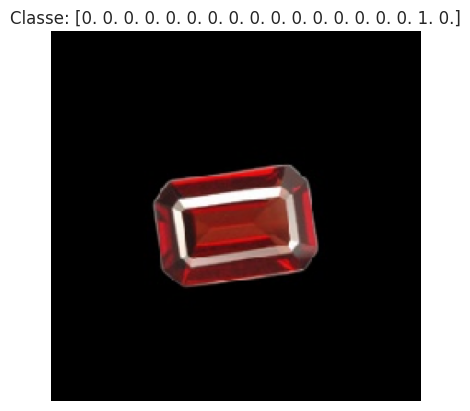

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Obtém o próximo lote (batch) de imagens e rótulos do gerador
images, labels = next(train_gen)

# Seleciona a primeira imagem do lote
for i in range(3):
    image = images[i]
    print(image[i])
    # Exibe a imagem
    plt.imshow(image)
    plt.axis('off')  # Remove os eixos
    plt.title(f"Classe: {labels[0]}")  # Exibe o rótulo da classe
    plt.show()


### build the model

In [12]:
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256,
        activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
x=Dropout(rate=.30, seed=123)(x)
x = Dense(128,
        activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)

output=Dense(len(classes), activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
### create function to print text in RGB foreground and background colors

In [14]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

###  create subclass of callbacks to control learning rate and print training data per epoch

In [15]:
class LRA(keras.callbacks.Callback):
    color = (255, 0, 0)
    reset = False
    count = 0
    stop_count = 0
    tepochs = 0

    def __init__(self, model, patience, stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model_internal = model  # Changed from self.model to self.model_internal
        self.patience = patience  # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience
        self.threshold = threshold  # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # factor by which to reduce the learning rate
        self.dwell = dwell
        self.learning_rate = float(tf.keras.backend.get_value(model.optimizer.learning_rate))  # get the initiallearning rate and save it in self.lr
        self.highest_tracc = 0.0  # set highest training accuracy to 0
        self.lowest_vloss = np.inf  # set lowest validation loss to infinity
        # self.count=0 # initialize counter that counts epochs with no improvement
        # self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement
        self.initial_epoch = initial_epoch
        # self.epochs=epochs
        self.best_weights = self.model_internal.get_weights()  # set a class variable so weights can be loaded after training is completed
        msg = ' '
        if freeze == True:
            msgs = f' Starting training using  base model {model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs = f' Starting training using base model {model_name} training all layers '
        print_in_color(msgs, (244, 252, 3), (55, 65, 80))

    def on_epoch_begin(self, epoch, logs=None):
        self.now = time.time()

    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        color = (0, 0, 255)
        later = time.time()
        duration = later - self.now
        if epoch == self.initial_epoch or LRA.reset == True:
            LRA.reset = False
            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss',
                                                                                                 'Accuracy', 'V_loss',
                                                                                                 'V_acc', 'LR',
                                                                                                 'Next LR', 'Monitor',
                                                                                                 'Duration')
            print_in_color(msg, (244, 252, 3), (55, 65, 80))

        learning_rate = float(tf.keras.backend.get_value(self.model_internal.optimizer.learning_rate))  # get the current learning rate
        current_lr = learning_rate
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        # print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold:  # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if acc > self.highest_tracc:  # training accuracy improved in the epoch
                self.highest_tracc = acc  # set new highest training accuracy
                self.best_weights = self.model_internal.get_weights()  # training accuracy improved so save the weights
                self.count = 0  # set count to 0 since training accuracy improved
                self.stop_count = 0  # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                color = (0, 255, 0)
                self.learning_rate = learning_rate
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1:
                    color = (255, 0, 0)
                    self.learning_rate = learning_rate * self.factor  # adjust the learning by factor
                    tf.keras.backend.set_value(self.model_internal.optimizer.learning_rate, self.learning_rate)  # set the learning rate in the optimizer
                    self.count = 0  # reset the count to 0
                    self.stop_count = self.stop_count + 1
                    if self.dwell:
                        self.model_internal.set_weights(self.best_weights)  # return to better point in N space
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1  # increment patience counter
        else:  # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if v_loss < self.lowest_vloss:  # check if the validation loss improved
                self.lowest_vloss = v_loss  # replace lowest validation loss with new validation loss
                self.best_weights = self.model_internal.get_weights()  # validation loss improved so save the weights
                self.count = 0  # reset count since validation loss improved
                self.stop_count = 0
                color = (0, 255, 0)
                self.learning_rate = learning_rate
            else:  # validation loss did not improve
                if self.count >= self.patience - 1:
                    color = (255, 0, 0)
                    self.learning_rate = self.learning_rate * self.factor  # adjust the learning rate
                    self.stop_count = self.stop_count + 1  # increment stop counter because lr was adjusted
                    self.count = 0  # reset counter
                    tf.keras.backend.set_value(self.model_internal.optimizer.learning_rate, self.learning_rate)  # set the learning rate in the optimizer
                    if self.dwell:
                        self.model_internal.set_weights(self.best_weights)  # return to better point in N space
                else:
                    self.count = self.count + 1  # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc
        msg = f'{str(epoch + 1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{self.learning_rate:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color(msg, color, (55, 65, 80))
        if self.stop_count > self.stop_patience - 1:  # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            self.model_internal.stop_training = True  # stop training

### instantiate the callback

In [16]:
epochs =10
patience= 2 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=False # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=True # if true free weights of  the base model
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing

 Starting training using  base model InceptionResNetV2 with weights frozen to imagenet weights initializing LRA callback



### train the model

In [18]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9989 - loss: 0.0056 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /300    0.005   99.887   2.40318  50.249   0.00100  0.00050  val_loss   18.65  

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.5025 - val_loss: 2.4032
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9989 - loss: 0.0034 2 /300    0.003   99.887   2.47810  50.249   0.00100  0.00050  val_loss   19.86  

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 0.5025 - val_loss: 2.4781
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9989 - loss: 0.0064 3 /300    0.006   99.887   2.61458  49.254   0.00100  0.00050  val_loss   16.94  

37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - accuracy: 0.9989 - loss: 0.0064 - val_accuracy: 0.4925 - val_loss: 2.6146
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accur

### define function to plot training data

In [19]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


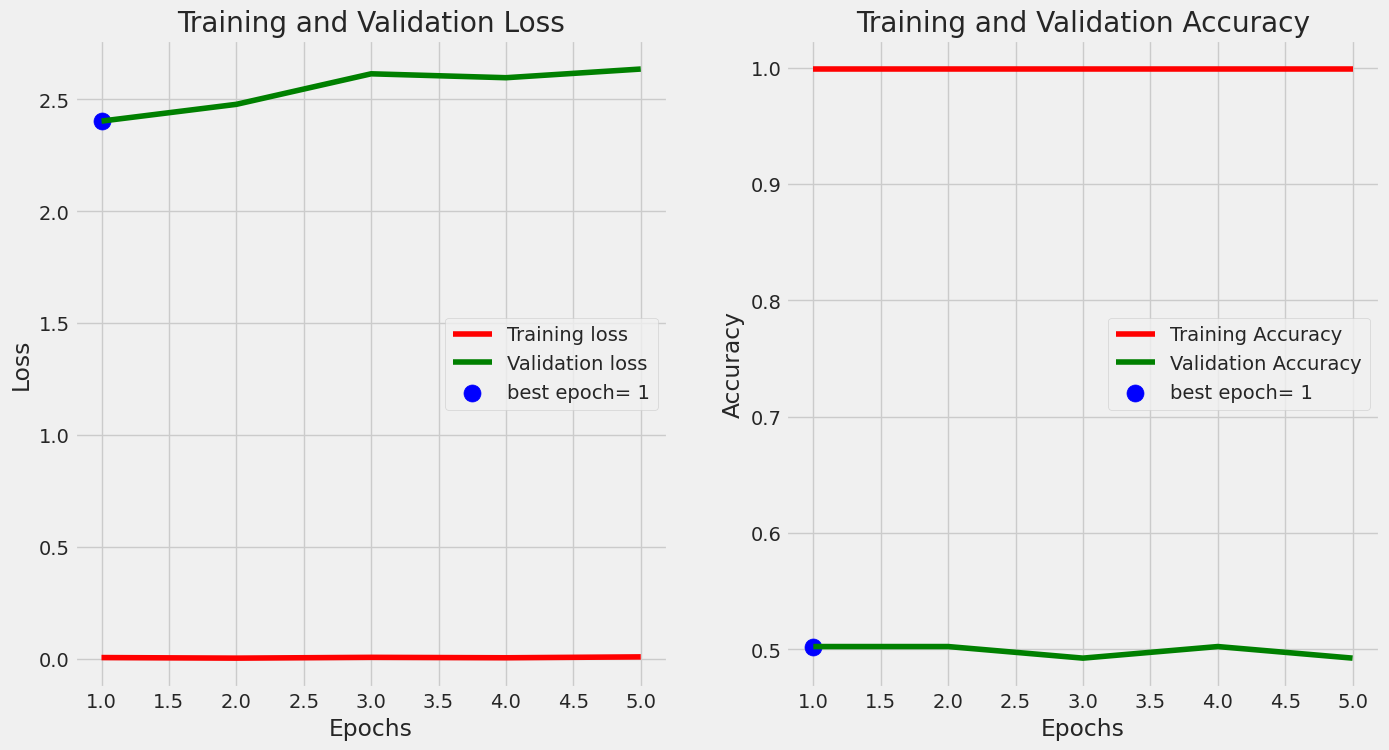

In [20]:
tr_plot(history, 0)

### evaluate model on test set

In [21]:
acc=model.evaluate(test_gen, verbose=1)[1]*100
print (' Accuracy on test set: ', acc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.4768 - loss: 2.6623
 Accuracy on test set:  48.500001430511475


### define function to generate confusion matrix and classification report report

In [22]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')

    if len(classes)<= 30:
        # create a confusion matrix and a test report
        y_true= np.array(labels)
        y_pred=np.array(y_pred)
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        print("Classification Report:\n----------------------\n", clr)

### save the model

In [23]:
save_dir=r'./'
subject='rocks'
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and show confusion matrix and classification report

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


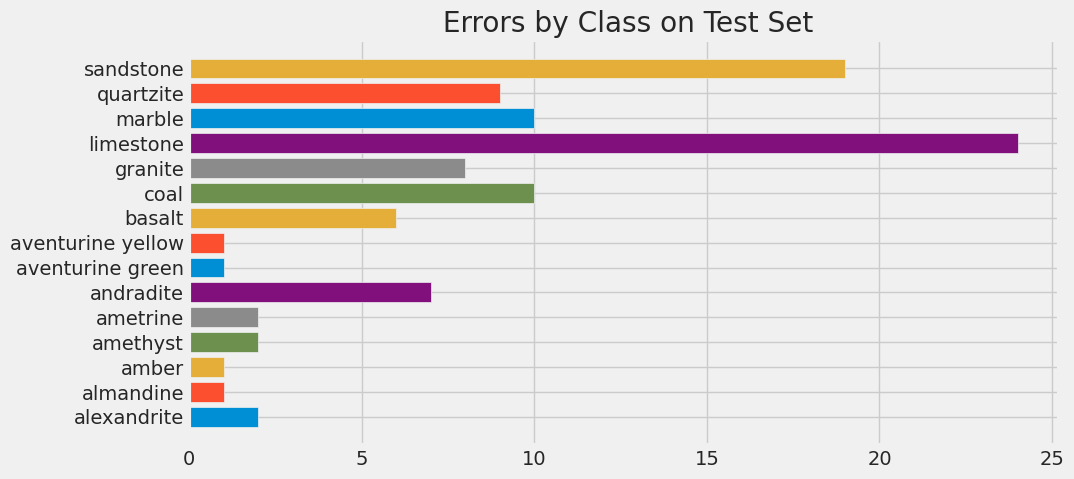

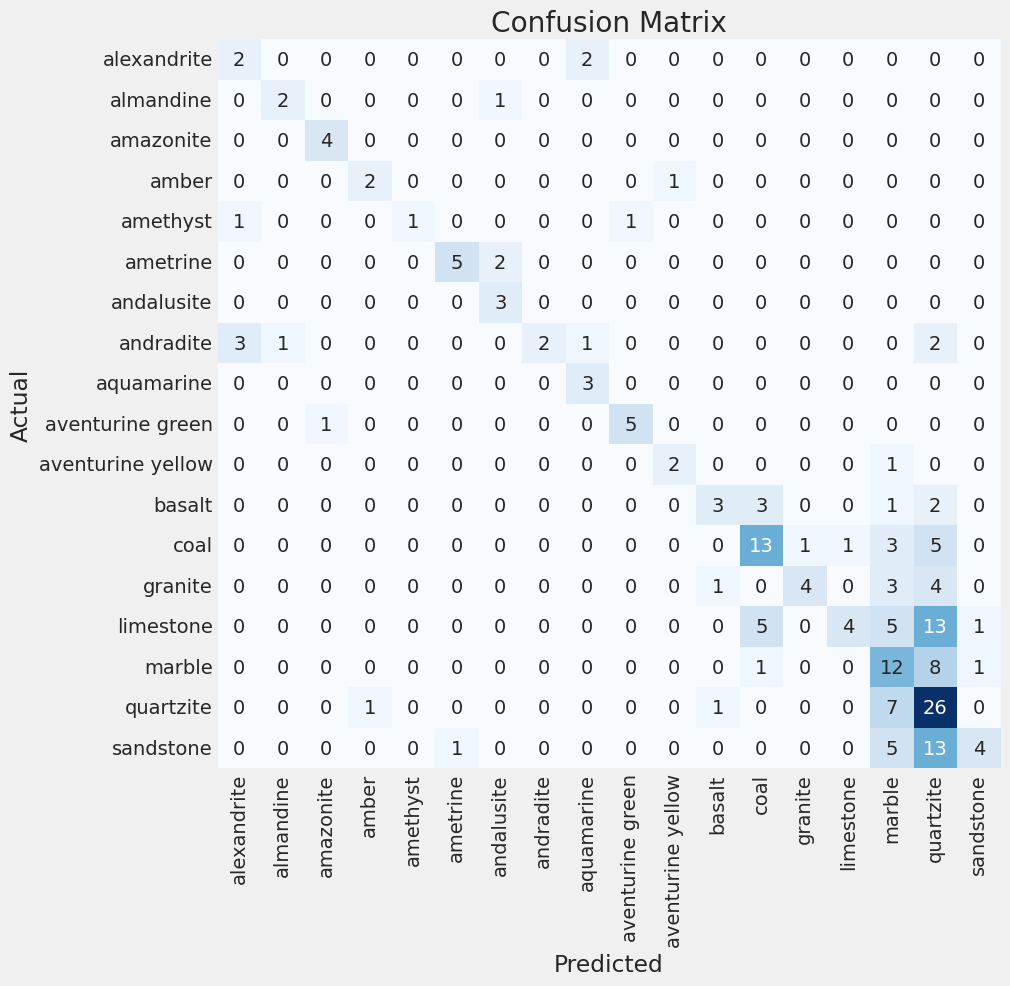

Classification Report:
----------------------
                    precision    recall  f1-score   support

      alexandrite       0.33      0.50      0.40         4
        almandine       0.67      0.67      0.67         3
        amazonite       0.80      1.00      0.89         4
            amber       0.67      0.67      0.67         3
         amethyst       1.00      0.33      0.50         3
         ametrine       0.83      0.71      0.77         7
       andalusite       0.50      1.00      0.67         3
        andradite       1.00      0.22      0.36         9
       aquamarine       0.50      1.00      0.67         3
 aventurine green       0.83      0.83      0.83         6
aventurine yellow       0.67      0.67      0.67         3
           basalt       0.60      0.33      0.43         9
             coal       0.59      0.57      0.58        23
          granite       0.80      0.33      0.47        12
        limestone       0.80      0.14      0.24        28
        

In [24]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )